## Info

- 테스트환경임
- API 리턴 데이터 형태를 지정
    - 보간설정, GPS 값으로 위치값 변환 등

In [7]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.preprocessing import MinMaxScaler


## 0. 데이터 로드 및 전처리

데이터 로드

In [9]:
# 공기품질 데이터 로드
df_airquality = pd.read_csv("data/air_quality_data.csv") 
airquality = df_airquality[["date_time","measure_position_id","pm10_value","pm25_value"]]

# 위치 데이터 로드
df_position = pd.read_csv("data/position_data.csv")
position = df_position[(df_position['id']>=1) & (df_position['id']<=12)].iloc[:12,:] # 위치값 1~12만 사용
position.rename(columns={"id":"measure_position_id"},inplace=True) # 컬럼명 변경

데이터 결합 및 데이터프레임 생성
- 위치 id 기준
- 결측치 채움
- 스케일링

In [10]:
# 공기품질 데이터 + 위치 데이터 결합 (위치id 기준)
merged_df = pd.merge(airquality, position, on='measure_position_id', how='left')
merged_df['measure_position_id'] = merged_df['measure_position_id'].astype("float64")
merged_df.drop("grid_x",axis=1,inplace=True)
merged_df.drop("grid_y",axis=1,inplace=True)
merged_df.drop("type",axis=1,inplace=True)
merged_df.drop("district_code",axis=1,inplace=True)
merged_df.drop("name",axis=1,inplace=True)

# 결측치 채우기
merged_df["pm10_value"] = merged_df['pm10_value'].fillna((merged_df["pm10_value"].ffill()+\
                                                          merged_df["pm10_value"].bfill())/2)
merged_df["pm25_value"] = merged_df['pm25_value'].fillna((merged_df["pm25_value"].ffill()+\
                                                          merged_df["pm25_value"].bfill())/2)

# 경도(X)와 위도(Y) 스케일링 (0~1)
scaler_X = MinMaxScaler() 
X_data = merged_df["longitude"].values.reshape(-1,1)
X_data = scaler_X.fit_transform(X_data)
scaler_Y = MinMaxScaler() 
Y_data = merged_df["latitude"].values.reshape(-1,1)
Y_data = scaler_Y.fit_transform(Y_data)

# 데이터프레임에 삽입
merged_df["new_longitude"]=X_data
merged_df["new_latitude"]=Y_data

# 저장
merged_df.to_csv("data/merged_df.csv")

위치정보 파일 생성
- 임시로 생성 (향후 사용안할 수 있음.)

In [11]:
# config 파일 생성
longitude = merged_df[:12]["longitude"].values # x
latitude = merged_df[:12]["latitude"].values # y
new_longitude = merged_df[:12]["new_longitude"].values # x
new_latitude = merged_df[:12]["new_latitude"].values # y
pos_id = merged_df[:12]["measure_position_id"].values
save_dict_config = {}
for pos,lo,la,newlo,newla in zip(pos_id,longitude,latitude,new_longitude,new_latitude):
    if not save_dict_config.get(pos):
        save_dict_config[pos]={"longitude":lo,
                        "latitude":la,
                        "new_longitude":newlo,
                        "new_latitude":newla,}
    else:
        pass

# JSON 파일로 저장
with open("configs/position_info.json", "w") as json_file:
    json.dump(save_dict_config, json_file, indent=4)

## 1. 위치(GPS) 데이터 생성
- 앞서 실제 경도,위도 기준으로 min-max scaler fit (0~1) 을 하였음.
- 생성할 배열은 가로 80, 세로 40
- 생성한 배열의 좌표값을 inverse scaling 하면 원래 GPS X,Y 추출 가능

In [17]:
# x와 y를 스케일링하여 2차원 배열 생성
x_values = np.linspace(0, 1, 80)
y_values = np.linspace(0, 1, 40)

# gps 값
gps_x_values = scaler_X.inverse_transform(x_values.reshape(-1,1))
gps_y_values = scaler_Y.inverse_transform(y_values.reshape(-1,1))

gps_x_pos = []
gps_y_pos = []
for yy in gps_y_values:
    for xx in gps_x_values:
       gps_x_pos.append(xx)
       gps_y_pos.append(yy)
gps_x_pos = np.array(gps_x_pos)
gps_y_pos = np.array(gps_y_pos)
gps_x_pos_save = gps_x_pos.flatten().tolist()
gps_y_pos_save = gps_y_pos.flatten().tolist()

## 2. sample data 생성
- 특정 날짜 기준으로 (위치, 시간, 미세먼지값) 데이터 생성

In [23]:
def make_sample_data(time,merged_df,x_values,y_values):
    
    # 사용할 날짜 지정 (특정시간이기 때문에, 데이터길이 12임)
    temp_df = merged_df[merged_df["date_time"]==time]

    # 사용할 값
    use_x = temp_df["new_longitude"].values
    use_y = temp_df["new_latitude"].values
    use_pm10 = temp_df["pm10_value"].values
    use_pm25 = temp_df["pm25_value"].values

    # 보간하기위한 값들 지정 (pm10, pm25, 위치값(배열))) 
    ust_point_lst = []
    pm10_lst = []
    pm25_lst = []
    for x,y,pm10,pm25 in zip(use_x,use_y,use_pm10,use_pm25):
        temp_x = np.abs(x_values-x)
        temp_y = np.abs(y_values-y)
        point_x = np.where(temp_x==np.min(temp_x))[0][0] # 오차가 제일 작은 위치
        point_y = np.where(temp_y==np.min(temp_y))[0][0] # 오차가 제일 작은 위치
        ust_point_lst.append([point_x,point_y]) # 오차가 제일 작은 위치(x,y) 저장 
        pm10_lst.append(pm10)
        pm25_lst.append(pm25)
    ust_point_lst = np.array(ust_point_lst) # 길이 12
    pm10_lst = np.array(pm10_lst) # 길이 12
    pm25_lst = np.array(pm25_lst) # 길이 12

    # 보간수행
    x, y = np.meshgrid(np.arange(80), np.arange(40))
    interpolated_values_pm10 = griddata(ust_point_lst, pm10_lst, (x, y), method='linear', fill_value=0)
    interpolated_values_pm25 = griddata(ust_point_lst, pm25_lst, (x, y), method='linear', fill_value=0)
    return interpolated_values_pm10,interpolated_values_pm25

In [31]:
# return 할 sample data dict 생성
save_dict = {"location":{"gps_x":gps_x_pos_save,
                         "gps_y":gps_y_pos_save}}

# 원하는 시간범위
times = sorted(list(set(merged_df[(merged_df["date_time"]>="2023-08-24 00:00:00") & (merged_df["date_time"]<="2023-08-27 00:00:00")]["date_time"].values)))
for time in times:
    interpolated_values_pm10,interpolated_values_pm25 = make_sample_data(time,merged_df,x_values,y_values)
    pm10_result = interpolated_values_pm10.flatten().tolist()
    pm25_result = interpolated_values_pm25.flatten().tolist()
    save_dict[time]={"pm10":pm10_result,
                     "pm25":pm25_result}

# 저장
with open("result/sample/sample_data.json","w") as json_file:
    json.dump(save_dict,json_file,indent=4)

## 3. Plotting

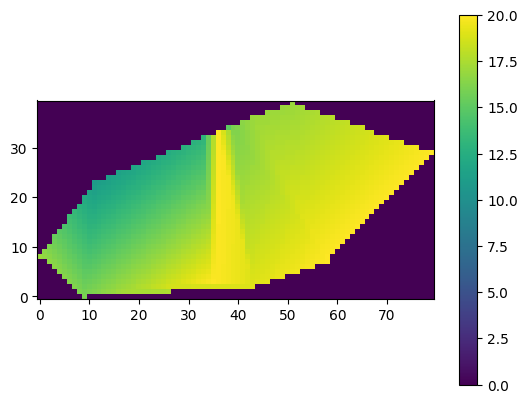

In [37]:
arr = np.array(save_dict['2023-08-24 00:00:00']['pm10'])
plt.imshow(arr.reshape(40,80),origin='lower')
plt.colorbar()